## **Character recognition**
###  Vien Bui, Caren Alexander, Sumanth Bail

---
- The goal of this project is to apply the machine learning algorithms learned in class on an interesing dataset to serve a real life need.

- The Character Font Images [dataset](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images) from UCI machine learning repository is selected. The dataset consists of 153 files conresponding to 153 fonts. Each file (of a font) holds a number of records which, for each, contains the image, label, and other info of a character. Those images were either scanned using devices such as hand\desktop scanners or cameras, or generated by computer.
- We aim to train a model(s) that helps convert an image of text to the corresponding text.

In [0]:
# Let's first load essential packages

import os
import os.path
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from IPython.display import Image, display, Math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.model_selection import train_test_split
from sklearn import metrics
from time import perf_counter as timer
from joblib import dump
import joblib
import cv2
import PIL


%matplotlib inline

In [0]:
# Now retrieve the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip

# unzips it and saves all the csv into Dataset folder
with zipfile.ZipFile('fonts.zip', 'r') as zip_ref:
    zip_ref.extractall('Dataset/')

--2019-12-10 02:51:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160313983 (153M) [application/x-httpd-php]
Saving to: ‘fonts.zip’

fonts.zip           100%[===================>] 152.89M  44.1MB/s    in 3.9s    

2019-12-10 02:51:26 (39.3 MB/s) - ‘fonts.zip’ saved [160313983/160313983]



In [0]:
# Load all the files and look at what's inside
def load(font_folder, file_list='all', verbose = True):
    if file_list == 'all':
        files = glob.glob(font_folder + "/*.csv")
    else:
        files = file_list
        for i in range(len(files)):
            files[i] = os.path.join(font_folder, files[i])
   
    li = []   
    for filename in files:
        lf = pd.read_csv(filename, index_col=None, header=0)
        # Add local data frame to list
        li.append(lf)
        if verbose == True:
            print("File Processed: ", filename)
     # Finally merge all data frames
    df = pd.concat(li, axis=0, ignore_index=True) 
    return df

df = load('Dataset')

File Processed:  Dataset/BUXTON.csv
File Processed:  Dataset/VIN.csv
File Processed:  Dataset/BRITANNIC.csv
File Processed:  Dataset/MISTRAL.csv
File Processed:  Dataset/MODERN.csv
File Processed:  Dataset/RICHARD.csv
File Processed:  Dataset/PROXY.csv
File Processed:  Dataset/GUNPLAY.csv
File Processed:  Dataset/NINA.csv
File Processed:  Dataset/CREDITCARD.csv
File Processed:  Dataset/FREESTYLE.csv
File Processed:  Dataset/LEELAWADEE.csv
File Processed:  Dataset/BITSTREAMVERA.csv
File Processed:  Dataset/BROADWAY.csv
File Processed:  Dataset/PANROMAN.csv
File Processed:  Dataset/MV_BOLI.csv
File Processed:  Dataset/PERPETUA.csv
File Processed:  Dataset/IMPACT.csv
File Processed:  Dataset/ROCKWELL.csv
File Processed:  Dataset/MONEY.csv
File Processed:  Dataset/CONSOLAS.csv
File Processed:  Dataset/ROMANTIC.csv
File Processed:  Dataset/QUICKTYPE.csv
File Processed:  Dataset/HIMALAYA.csv
File Processed:  Dataset/COURIER.csv
File Processed:  Dataset/HARRINGTON.csv
File Processed:  Dataset

In [0]:
# View the data
df

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,h,w,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,r0c10,r0c11,r0c12,r0c13,r0c14,r0c15,r0c16,r0c17,r0c18,r0c19,r1c0,r1c1,r1c2,r1c3,r1c4,r1c5,r1c6,r1c7,...,r18c0,r18c1,r18c2,r18c3,r18c4,r18c5,r18c6,r18c7,r18c8,r18c9,r18c10,r18c11,r18c12,r18c13,r18c14,r18c15,r18c16,r18c17,r18c18,r18c19,r19c0,r19c1,r19c2,r19c3,r19c4,r19c5,r19c6,r19c7,r19c8,r19c9,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,BUXTON,BUXTON SKETCH,64258,0.4,0,0.0,22,19,58,33,20,20,1,1,1,1,1,1,1,1,87,194,255,255,255,250,168,168,168,97,1,1,1,1,1,1,1,1,96,169,...,1,1,1,1,194,255,255,235,43,1,1,1,1,1,32,222,255,255,241,79,1,1,1,1,74,168,221,147,1,1,1,1,1,1,1,20,82,168,168,114
1,BUXTON,BUXTON SKETCH,64257,0.4,0,0.0,22,19,57,30,20,20,1,1,1,1,1,1,1,1,26,77,196,255,255,255,226,106,1,1,1,1,1,1,1,1,1,1,1,102,...,1,1,1,1,255,255,255,255,171,1,1,1,1,1,51,221,255,255,205,44,1,1,1,1,196,255,226,166,51,1,1,1,1,1,1,51,196,255,255,196
2,BUXTON,BUXTON SKETCH,9674,0.4,0,0.0,38,22,40,32,20,20,1,1,1,1,1,1,1,1,144,255,255,240,64,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,64,240,255,255,240,64,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,32,208,255,144,1,1,1,1,1,1,1,1
3,BUXTON,BUXTON SKETCH,8976,0.4,0,0.0,54,23,19,25,20,20,1,1,1,205,205,1,1,1,1,1,1,1,1,1,1,1,255,255,255,52,1,97,242,253,253,242,242,242,...,52,255,255,255,194,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,52,255,255,255,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,BUXTON,BUXTON SKETCH,8805,0.4,0,0.0,49,22,28,24,20,20,1,1,37,195,255,225,73,73,25,1,1,1,1,1,1,1,1,1,1,1,1,49,201,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,171,1,1,1,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,225,49,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832665,FORTE,FORTE,37,0.7,1,0.0,32,30,55,56,20,20,1,1,1,1,1,45,156,242,255,189,58,1,1,1,1,1,40,163,255,222,1,1,1,4,146,247,255,255,...,14,47,40,1,1,1,1,1,201,255,255,255,255,231,57,1,1,1,1,1,1,1,1,1,1,1,1,1,95,229,255,236,150,15,1,1,1,1,1,1
832666,FORTE,FORTE,36,0.7,1,0.0,32,24,53,46,20,20,1,1,1,1,1,1,1,1,1,1,9,63,143,159,159,235,255,214,255,145,1,1,1,1,1,1,1,1,...,17,217,242,158,248,113,3,1,1,1,1,1,1,1,1,1,1,1,1,1,117,230,55,244,158,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
832667,FORTE,FORTE,35,0.7,1,0.0,33,25,46,52,20,20,1,1,1,1,1,1,1,1,1,154,255,255,255,20,1,1,174,255,255,243,1,1,1,1,1,1,1,1,...,132,255,255,255,85,1,1,151,255,255,255,65,1,1,1,1,1,1,1,1,243,255,255,179,8,1,18,245,255,255,162,6,1,1,1,1,1,1,1,1
832668,FORTE,FORTE,34,0.7,1,0.0,31,39,18,28,20,20,1,1,1,1,1,73,255,255,255,255,255,255,37,110,255,255,255,255,255,255,1,1,1,1,1,235,255,255,...,255,255,255,255,235,1,1,37,255,255,255,255,199,1,1,1,1,1,1,1,255,255,255,255,73,1,1,37,255,255,255,255,37,1,1,1,1,1,1,1


- The total number of records across all font files (153) is **832670** which is quite large.
- m_label feature is the label of the character which is in ASCII.
- Feature r0c0 to r19c19 is the pixel values of the image.

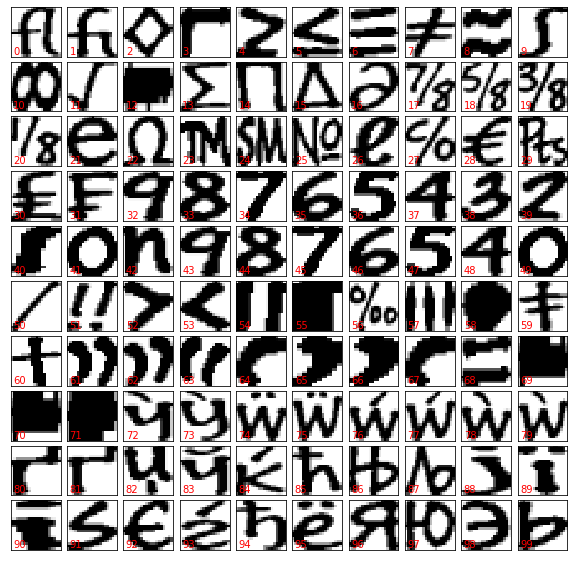

In [0]:
# Let's visualize some images in the dataset
df1 = df.drop(['font', 'fontVariant', "m_label", "strength", "italic","orientation", "m_top", "m_left", "originalH", "originalW", "h", "w"], axis=1)

images = df1.values
images = np.reshape(images, (images.shape[0], 20, 20))

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(i), transform=ax.transAxes, color='red')
    ax.set_xticks([])
    ax.set_yticks([])

- Turn out the dataset contain a huge variety of characters
- We decided to limit the characters to just digits(0-9) and alphabets(A-Z,a-z) as well as comma, and period.

In [0]:
# We will now filter out the records of the characters of interest. Let's see how many record do we have left.
def charactersOfInterest(df):
    # Chracters of interest
    chr_list = ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e"
            ,"f","g","h","i","j","k","l","m","n","o","p","q","r","s","t"
            ,"u","v","w","x","y","z","A","B","C","D","E","F","G","H","I"
            ,"J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X"
            ,"Y","Z",".",","]

    # Create new column
    df['ascii'] = [chr(x) for x in df['m_label']]
    df_work = df[df['ascii'].isin(chr_list)]
    return df_work

df_work = charactersOfInterest(df)
print(df_work.shape[0])

337481


In [0]:
# We need to extract the image data and the corresponding labels
def setXy(df_work):
    X = df_work.drop(['ascii','font', 'fontVariant', 
                    "m_label", "strength", "italic",
                    "orientation", "m_top", "m_left", 
                    "originalH", "originalW", "h", "w"], axis=1).values
    X = X/255  #to scale the values between 0 and 1
    y = df_work["ascii"].values
    return X,y

X,y = setXy(df_work)
print(X.shape)
print(y.shape)

(337481, 400)
(337481,)


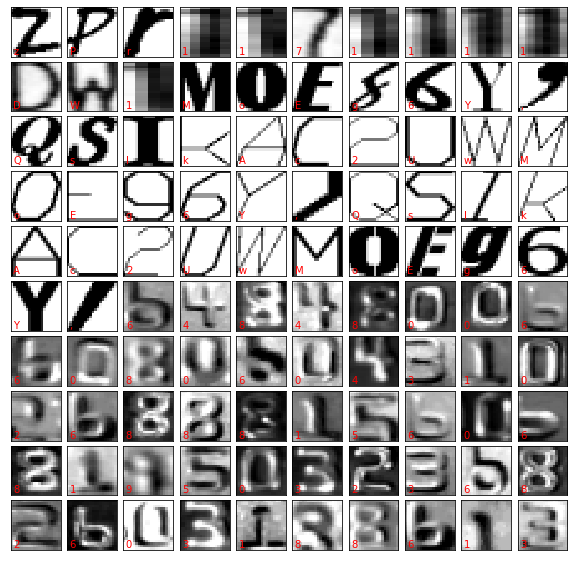

In [0]:
# View some images from X
images = np.reshape(X, (X.shape[0], 20, 20))

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[100*i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, y[100*i], transform=ax.transAxes, color='red')
    ax.set_xticks([])
    ax.set_yticks([])

In [0]:
# Before training, the data is split into a testing set and a training set. The split by default will be 75% for the training set and 25% for the testing set.
def testTrainSplit(X,y):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
    return Xtrain, Xtest, ytrain, ytest

Xtrain, Xtest, ytrain, ytest = testTrainSplit(X,y)

In [0]:
# For now, let's just jump right in a build a model, says Logistic Regression
clf = LogisticRegression(max_iter=200, solver='newton-cg', multi_class='auto')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LogisticRegression: ", metrics.accuracy_score(ypred, ytest))

KeyboardInterrupt: ignored

The training process took forever since the number of instences is large and Logistic Regression does not scale well. That also means other more advanced models such SVM will not be feasible. We decided to stop the program and look for solutions.

We found this as a good guideline:![alt text](https://scikit-learn.org/stable/_static/ml_map.png)

Here are 2 options and we chose to purse both of them:
- Reduce the number of instances to under 100K by selecting only common fonts
- Train with the whole dataset by using mini-batch learning together with SGDClassifier and Kernel approximation.


### **Option 1**: Reduce the number of instances to under 100K by selecting only common fonts

In [0]:
# instead of using data from all files, we just use data from the following files (common fonts)
df = load('Dataset', ['ARIAL.csv','CALIBRI.csv','CAMBRIA.csv','HANDPRINT.csv','TAHOMA.csv','TIMES.csv'])
print(df.shape[0])

File Processed:  Dataset/ARIAL.csv
File Processed:  Dataset/CALIBRI.csv
File Processed:  Dataset/CAMBRIA.csv
File Processed:  Dataset/HANDPRINT.csv
File Processed:  Dataset/TAHOMA.csv
File Processed:  Dataset/TIMES.csv
150925


In [0]:
#filter out the records of the characters of interest
df_work = charactersOfInterest(df)

# extract the image data and the corresponding labels
X,y = setXy(df_work)

# Split data in training/testing set
Xtrain, Xtest, ytrain, ytest = testTrainSplit(X,y)

In [0]:
# Also apply PCA to reduce the data size
# The following function helps us pick the right percentage of explained variance
def plot_pca_explain(pca):
    plt.figure(figsize=(10, 4))
    plt.style.use('ggplot')
    plt.plot(np.cumsum(pca.explained_variance_ratio_), '--s')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance (Cumulative)')
    plt.xticks(np.arange(0, 400, 25.0))
    plt.yticks(np.arange(0,1.1, 0.1))
    plt.show()
    
def pca_fit(data, explained):
    pca = PCA(explained)
    pca.fit(data)
    data_transformed = pca.transform(data)
    plot_pca_explain(pca)
    return data_transformed, pca

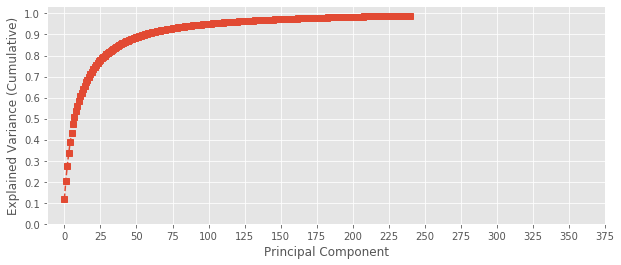

In [0]:
# Looking at the PCA for an explained variance of 99%
Xtrain_transformed, pca = pca_fit(Xtrain,0.99)

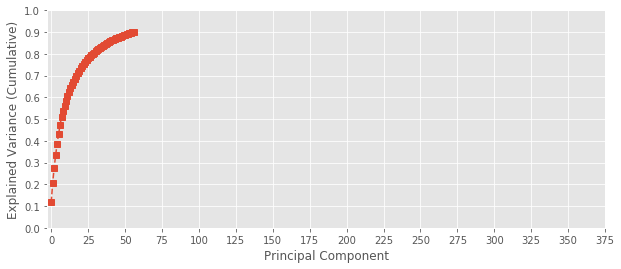

In [0]:
# Reducing it to an explained variance of 90% since the number of features gets large quickly after 90%
Xtrain_transformed, pca = pca_fit(Xtrain,0.90)

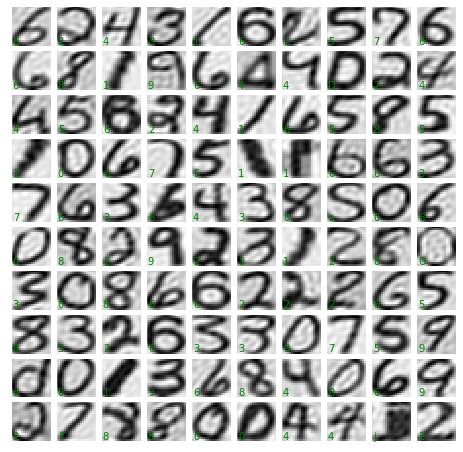

In [0]:
# Display some images from Xtrain_transformed to see how the image quality is affected
def viewResults(Xtest, ypred, ytest, pca):
    images = pca.inverse_transform(Xtest)
    images = np.reshape(images, (images.shape[0], 20, 20))

    fig, axes = plt.subplots(10, 10, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[100*i], cmap='binary', interpolation='nearest')
        ax.text(0.05, 0.05, ypred[100*i],
                transform=ax.transAxes, color='green' if (ytest[100*i] == ypred[100*i]) else 'red')
        ax.set_xticks([])
        ax.set_yticks([])

viewResults(Xtrain_transformed, ytrain, ytrain, pca)

In [0]:
# Also apply PCA to Xtest
Xtrain = Xtrain_transformed
Xtest = pca.transform(Xtest)

We are now ready to apply different models on the dataset: Decision tree, Logistic regression, Linear SVC, KNeighbors Classifier, RandomForest, and SVC.

In [0]:
# Decision tree
clf = DecisionTreeClassifier()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("DecisionTreeClassifier's accuracy score: ",metrics.accuracy_score(ypred, ytest))

DecisionTreeClassifier's accuracy:  0.8668832743319916


In [0]:
# Logistic regression
clf = LogisticRegression(max_iter=200, solver='newton-cg', multi_class='auto')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LogisticRegression's accuracy score: ",metrics.accuracy_score(ypred, ytest))

LogisticRegression's accuracy score:  0.9225061830173125


In [0]:
# Linear SVC
clf = LinearSVC(max_iter=2000)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LinearSVC's accuracy score: ",metrics.accuracy_score(ypred, ytest))

LinearSVC's accuracy score:  0.9107220794335871


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
# KneighborsClassifier, let's time the process to see how long it takes
start = timer()
clf = KNeighborsClassifier(n_neighbors = 3)
clf = clf.fit(Xtrain, ytrain)
end = timer()
diff = end-start
print("Finished in: " + str(diff*1e3) + " ms")

ypred = clf.predict(Xtest)
print("KnnClassifier's accuracy score: ", metrics.accuracy_score(ypred, ytest))

Finished in: 228.19765500025824 ms
KnnClassifier's accuracy score:  0.9735706318801222


In [0]:
# RandomForest, let's time the process to see how long it takes
start = timer()
clf = RandomForestClassifier(n_estimators=200)
clf.fit(Xtrain, ytrain)
end = timer()
diff = end-start
print("Finished in: " + str(diff*1e3) + " ms")

ypred = clf.predict(Xtest)
print("RandomForestClassifier's accuracy score: ",metrics.accuracy_score(ypred, ytest))

Finished in: 202094.70961700572 ms
RandomForestClassifier's accuracy score:  0.9544638960283206


In [0]:
# SVC with RBF kernel, let's time the process to see how long it takes
start = timer()
clf = SVC(kernel='rbf', C=1.1, gamma = 'scale')
clf.fit(Xtrain, ytrain)
end = timer()
diff = end-start
print("Finished in: " + str(diff*1e3) + " ms")

ypred = clf.predict(Xtest)
print("SVC: ",metrics.accuracy_score(ypred, ytest))

Finished in: 73817.70856500225 ms
SVC:  0.9814267009359391


Among all, SVC presents the best performance with accuracy score of 0.9814267009359391

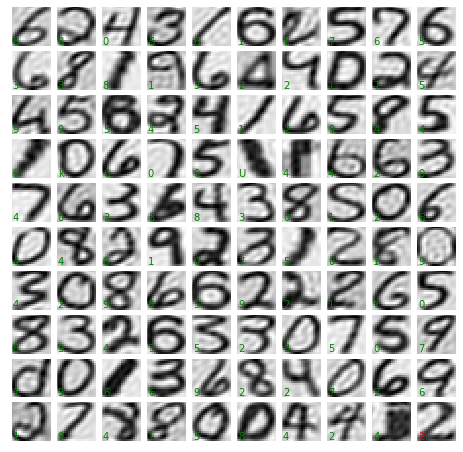

In [0]:
# Let's display some classification result
viewResults(Xtrain, ypred, ytest, pca)

In [0]:
# Let's save the SVC model and PCA object for later use
dump(clf, 'SVC.joblib')
dump(pca, 'PCA.joblib')

['PCA.joblib']

### **Option 2**: Train with the whole dataset by using mini-batch learning together with SGDClassifier and Kernel approximation

In [0]:
# Load the whole dataset
df = load('Dataset')

#filter out the records of the characters of interest
df_work = charactersOfInterest(df)

# extract the image data and the corresponding labels
X,y = setXy(df_work)

# Split data in training/testing set
Xtrain, Xtest, ytrain, ytest = testTrainSplit(X,y)

File Processed:  Dataset/BUXTON.csv
File Processed:  Dataset/VIN.csv
File Processed:  Dataset/BRITANNIC.csv
File Processed:  Dataset/MISTRAL.csv
File Processed:  Dataset/MODERN.csv
File Processed:  Dataset/RICHARD.csv
File Processed:  Dataset/PROXY.csv
File Processed:  Dataset/GUNPLAY.csv
File Processed:  Dataset/NINA.csv
File Processed:  Dataset/CREDITCARD.csv
File Processed:  Dataset/FREESTYLE.csv
File Processed:  Dataset/LEELAWADEE.csv
File Processed:  Dataset/BITSTREAMVERA.csv
File Processed:  Dataset/BROADWAY.csv
File Processed:  Dataset/PANROMAN.csv
File Processed:  Dataset/MV_BOLI.csv
File Processed:  Dataset/PERPETUA.csv
File Processed:  Dataset/IMPACT.csv
File Processed:  Dataset/ROCKWELL.csv
File Processed:  Dataset/MONEY.csv
File Processed:  Dataset/CONSOLAS.csv
File Processed:  Dataset/ROMANTIC.csv
File Processed:  Dataset/QUICKTYPE.csv
File Processed:  Dataset/HIMALAYA.csv
File Processed:  Dataset/COURIER.csv
File Processed:  Dataset/HARRINGTON.csv
File Processed:  Dataset

In [0]:
# Define a function to split the data into mini-batch
def batch(iterable_X, iterable_y, n=1):
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]

# Define classes for classification
classes = ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e"
            ,"f","g","h","i","j","k","l","m","n","o","p","q","r","s","t"
            ,"u","v","w","x","y","z","A","B","C","D","E","F","G","H","I"
            ,"J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X"
            ,"Y","Z",".",","]  

SGDClassifier implements regularized **linear** models with stochastic gradient descent (SGD) learning. Therefore, we should apply Kernel approximation to introduce non-linearity into the model.

In [0]:
# Apply Nystroem Kernel Approximation to the data
feature_map_nystroem = Nystroem(kernel='rbf', gamma=0.02, random_state=1, n_components=2000)
feature_map_nystroem.fit(Xtrain[0:10000])
# feature_map_nystroem.fit(Xtrain)
Xtest_features = feature_map_nystroem.transform(Xtest)

In [0]:
# Train SGDClassifier with online learning and Kernel Approximation on each chunk
clf = SGDClassifier(n_jobs=-1, alpha=0.000001, learning_rate='optimal') 
rounds = 10

for r in range(rounds):
    print("ROUND " + str(r+1) + " :")
    batcherator = batch(Xtrain, ytrain, 50000)
    for index, (chunk_X, chunk_y) in enumerate(batcherator):
        chunk_X_features = feature_map_nystroem.transform(chunk_X)
        clf.partial_fit(chunk_X_features, chunk_y, classes=classes)

        ypred = clf.predict(Xtest_features)
        print("Accuracy score: " + str(metrics.accuracy_score(ytest, ypred)))

ROUND 1 :
Accuracy score: 0.8276896089888706
Accuracy score: 0.8326913275888634
Accuracy score: 0.8797691149802658
Accuracy score: 0.8950705811238459
Accuracy score: 0.8832774294485072
Accuracy score: 0.8839293122044304
ROUND 2 :
Accuracy score: 0.8875442983963684
Accuracy score: 0.8962084128432756
Accuracy score: 0.8977966362849794
Accuracy score: 0.8991715162792903
Accuracy score: 0.9065792748693271
Accuracy score: 0.907160043142786
ROUND 3 :
Accuracy score: 0.898910763176921
Accuracy score: 0.9038413672944495
Accuracy score: 0.9021820293702812
Accuracy score: 0.904931789358903
Accuracy score: 0.9141292624242927
Accuracy score: 0.9013405079944531
ROUND 4 :
Accuracy score: 0.9144611300091263
Accuracy score: 0.9172820044802124
Accuracy score: 0.915598961728556
Accuracy score: 0.9152552417299783
Accuracy score: 0.9178509203399272
Accuracy score: 0.9160849106920624
ROUND 5 :
Accuracy score: 0.9185857699920589
Accuracy score: 0.9185739175783149
Accuracy score: 0.9176968389612544
Accuracy 

The resulting accuracy score is 0.9236941603157482 which is impressive for a large dataset.

In [0]:
# Let's save the SGD model and feature_map_nystroem object for later use
dump(feature_map_nystroem, 'featuremap.joblib')
dump(clf, 'SGD.joblib')

['SGD.joblib']

### **Apply the models to read scanned documents**


#### Using SVC for predictions
Since SVC was one of the algorithms that gave us a great accuracy score, we will use it to make prediction for the letters in our image. We will load our saved model and then apply it to simple images of text. 

To be able to make predictions, we will read in the images, apply contours to them to be able to extract characters, resize them, and then use our model to get a prediction.

In [0]:
# load pca
pca = joblib.load('PCA.joblib')

In [0]:
# load the SVC model
msvc = joblib.load('SVC.joblib')

In [0]:
# We need to make sure we have opencv for reading in images
!pip install opencv-python

Images/Capture2.JPG


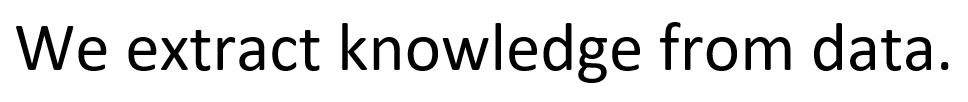

In [77]:
# First we will get all of the image files

image_files = glob.glob(os.path.join("Images", "*"))

for (i, image_file) in enumerate(image_files):
    if i==10: break
    print(image_file)
    display(Image(filename=image_file))

Before we can make our predictions with the provided image files, we will need to define a couple functions that will get us the desired images of the characters. 

In [0]:
# get the contours for an image

def getContours(file):
  image = cv2.imread(file)
  # change it to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # Add some extra padding around the image
  gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
  # threshold the image (convert it to pure black and white)
  # we use Otsu’s binarization
  # check: https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  # find the contours (continuous blobs of pixels) the image
  # check:
  # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started
  contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  return gray, contours

In [0]:
# get the regions of bounding boxes of the contours

def getBoundingBoxes(gray, contours):
  letter_image_regions = []

  # Now we can loop through each of the four contours and extract the letter
  # inside of each one
  for contour in contours:
      # Get the rectangle that contains the contour
      (x, y, w, h) = cv2.boundingRect(contour)
      letter_image_regions.append((x, y, w, h))
      letter_image = gray[y:y+h, x:x+w]
      # plt.imshow(letter_image)
      # plt.show()
  # Sort the detected letter images based on the x coordinate to make sure
  # we are processing them from left-to-right so we match the right image
  # with the right letter
  letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

  # Create an output image and a list to hold our predicted letters
  output = cv2.merge([gray] * 3) # 2D gray image -> 3D color image


  #Show the image with matplotlib
  plt.imshow(output)
  plt.show()

  return letter_image_regions

In [0]:
# function to resize the images to match the datset we have trained with

def resize_to_fit(image, width, height):
  new_im = PIL.Image.fromarray(image)
  im_resize = new_im.resize((width, height))
  np_im = np.array(im_resize)
  return np_im

In [0]:
# Now we have everything we need to make our predictions

def getPredictions(letter_image_regions, model, aux_object):
  predictions = []
  letter_images = []
  # Save out each letter as a single image
  for letter_bounding_box in letter_image_regions:
      # Grab the coordinates of the letter in the image
      x, y, w, h = letter_bounding_box

      # Extract the letter from the original image with a 2-pixel margin around the edge
      letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]


      # Re-size the letter image to 20x20 pixels to match training data
      letter = resize_to_fit(letter_image, 20, 20)

      # adjust for invers coloring
      letter = 255 - letter
      
      letter_images.append(letter)

      # make a 1-dimensional view of arr and adjust for invers coloring
      letter = np.matrix(letter.ravel())/255    
      
      # Ask SVC to make a prediction
      prediction = model.predict(aux_object.transform(letter))[0]

      predictions.append(prediction)

      # show image and its prediction
      # plt.imshow(letter_image)
      # plt.xlabel("Prediction: " + prediction)
      # plt.show()

  fig, axes = plt.subplots(1, len(letter_images), figsize=(30,10))
  fig.subplots_adjust(hspace=0.1, wspace=0.1)

  for i, ax in enumerate(axes.flat):
    ax.imshow(letter_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, predictions[i], transform=ax.transAxes, color='red')
    ax.set_xticks([])
    ax.set_yticks([])

  return predictions

Now we have the necessary functions to be able to get predictions for provided images. 

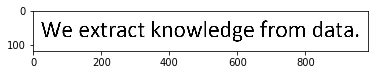

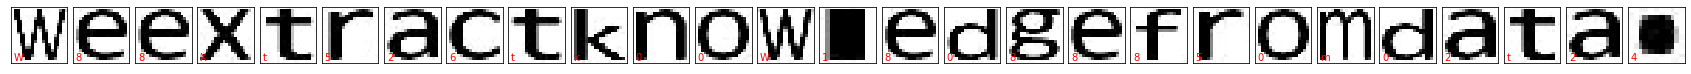

In [100]:
# Predict only the first image from the Images folder
gray, contours = getContours(image_files[0])
letter_image_regions = getBoundingBoxes(gray, contours)
predictions = getPredictions(letter_image_regions, msvc, pca)

Look at the resulf above, we can tell that SVC model does not work as expected. There are too many misclassifications.

#### Using SGD for predictions
Now let's try SGD model which was trained on the whole dataset to see if it works any better.

In [0]:
# load SGD and feature mapping object
featuremap = joblib.load('featuremap.joblib')
sgd = joblib.load('SGD.joblib')

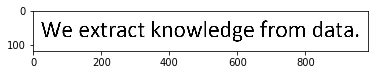

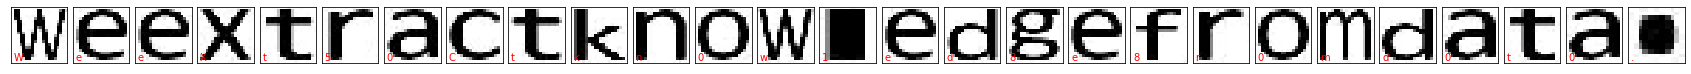

In [102]:
# Predict only the first image from the Images folder
gray, contours = getContours(image_files[0])
letter_image_regions = getBoundingBoxes(gray, contours)
predictions = getPredictions(letter_image_regions, sgd, featuremap)

In [103]:
# Let's display the predictions
print(predictions)

['W', 'e', 'e', 'X', 't', '5', '0', 'C', 't', 'k', 'n', '0', 'w', '1', 'e', 'd', '8', 'e', '8', 'r', '0', 'm', 'd', '0', 't', '0', '.']


This SGD model works a lot better than the previous SVC model which was trained only on a small subset of the dataset (common fonts).

### **Summary**

Through this project, the following model and techniques have been applied:
- Logistic Regression
- Decision tree
- Ensemble Classifier: Random Forest
- Knn Classifier
- SVM classifier: linear and RBF kernel
- PCA
- Online learning/Mini-batch learning with SGD classifier
- Kernel approximation
- How to deal with large dataset

The predicting result of SGD model which was trained using mini-batch learning and kernel approximation is quite impressive even though this model is much less flexible compared to a neural network model.
